In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [21]:
class Env():
    """
    A super simple environment to play with.
    A multi-armed bandit. It has n arms. Each arm has a mean/stddev.
    """
    def __init__(self, n_bandits, maxsteps=500):
        self.n_bandits = n_bandits
        self.means = np.random.standard_normal(n_bandits)
        self.stddev = np.abs(np.random.standard_normal(n_bandits))
        
        self.reset()
        self.maxsteps = maxsteps
        
    def step(self, action):
        reward = self.means[action] + self.stddev[action] * 0.1*np.random.standard_normal()
        
        if self.timestep >= self.maxsteps-1:
            done = True
            self.reset()
        else:
            done = False
            self.timestep += 1
            
        return self.timestep+1, reward, done
    
    def reset(self):
        self.timestep = 0
        return self.timestep, 0, False
    
    def show(self):
        plt.figure(figsize=(8, 4))
        plt.title('Bandit arm values')
        plt.bar(range(self.n_bandits), self.means, 0.5, yerr=self.stddev)
        plt.xlabel('Arms')
        plt.ylabel('Payoff')

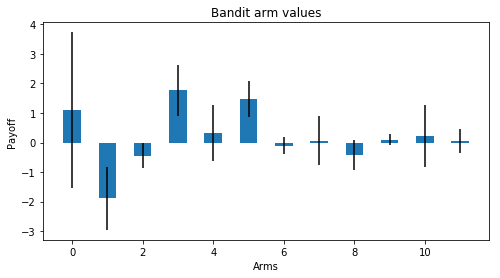

In [22]:
n_arms = 12
bandit = Env(n_arms)
bandit.show()

In [23]:
def play_episode(player, env, is_training):
    obs, r, done = env.reset()
    rewards = []
    while not done:
        a = player(obs, r, done, is_training)
        obs, r, done = env.step(a)
        rewards.append(r)
    a = player(obs, r, done)
    return rewards

def eval_player(env, player, n_episodes, is_training=True):
    """
    Args:
        env: must have a callable env.step fn that takes [state x action)s and returns (new_state, reward)
        player: a callable fn that returns actions given the current state
    """
    R = []
    for i in range(n_episodes):

        rs = play_episode(player, env, is_training)
        r = np.mean(rs)
        R.append(r)

        print('\rStep: {}, r: {}'.format(i, r), end='', flush=True)

    return R

In [61]:
def softmax(x):
    return np.exp(x)/np.sum(np.exp(x))

class UCB():
    def __init__(self, action_space):
        self.action_space = action_space
        self.n_actions = len(self.action_space)

        self.lr = 1.0
        self.reset()
        
        self.old_a = None

    def choose_action(self, s):
        s = 0
        p = softmax(self.vals)
        a = np.random.choice(self.action_space, p=p)

        return a
    
    def __call__(self, s, r, done, *args):
        a = self.choose_action(s)
        
        if self.old_a is not None:
            self.train_step(self.old_a, r)
                
        # loop past actions so we can use them for training
        self.old_a = a
        
        if done:
            self.reset()
                
        return a
    
    def train_step(self, old_a, r):
        delta =  r - self.vals[old_a]  # target - estimate
        self.vals[old_a] += self.lr * delta  # incremental update. exp avg/GD!
        
    def reset(self):
        self.vals = np.zeros([self.n_actions])
    
        self.old_a = None
        self.old_r = None
        
class UCBHoeffding():
    def __init__(self, action_space):
        self.action_space = action_space
        self.n_actions = len(self.action_space)

        self.lr = 0.1
        self.reset()

    def choose_action(self, s):
        s = 0
        p = softmax(self.vals)
        a = np.random.choice(self.action_space, p=p)

        self.counts[a] += 1

        return a
    
    def __call__(self, s, r, done, *args):
        a = self.choose_action(s)
        
        if np.sum(self.counts)>1 and not done:
            self.train_step(self.old_a, r)
                
        # loop past actions so we can use them for training
        self.old_a = a
        
        if done:
            self.reset()
                
        return a
    
    def train_step(self, old_a, r):
        lr = (100+1) / (100+self.counts[old_a])
        b = 1/np.sqrt(self.counts[old_a]+1)  # Hoeffding bonus
        delta =  r + self.vals[old_a] + b
        self.vals[old_a] = (1-lr)*self.vals[old_a] + lr * delta  # incremental update. exp avg/GD!
        
    def reset(self):
        self.vals = np.zeros([self.n_actions])
        self.counts = np.zeros([self.n_actions])
    
        self.old_a = None
        self.old_r = None

In [62]:
def plot_T(player, name, episode_len=100):
    # the reward as a fn of episode length
    # averaged over many episodes
    rs = np.vstack([play_episode(env=Env(n_arms, episode_len), player=player, is_training=False) 
                    for _ in range(2000)])
    # NOTE sometimes UCB does worse than random!?!?!? 
    # if you set env = constant_bandit you should see this

    mean = np.mean(rs, axis=0)
    stddev = np.sqrt(np.var(rs,axis=0))

    # smoothing
    n_kernel = 3
    kernel = [1]*n_kernel
    mean = np.convolve(mean, kernel)[n_kernel:len(mean)]/n_kernel
    stddev = np.convolve(stddev, kernel)[n_kernel:len(stddev)]/n_kernel

    
    plt.plot(range(len(mean)), mean, label=name)
    plt.fill_between(range(len(mean)), mean-stddev, mean+stddev,  alpha=0.3)

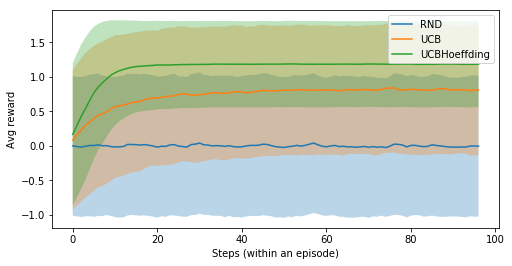

In [63]:
plt.figure(figsize=(8, 4))
player = lambda *x: np.random.randint(0, n_arms)
plot_T(player, 'RND', 100)

player = UCB(range(n_arms))
plot_T(player, 'UCB', 100)

player = UCBHoeffding(range(n_arms))
plot_T(player, 'UCBHoeffding', 100)

plt.xlabel('Steps (within an episode)')
plt.ylabel('Avg reward')
plt.legend()

Step: 499, r: 0.91029095144309487

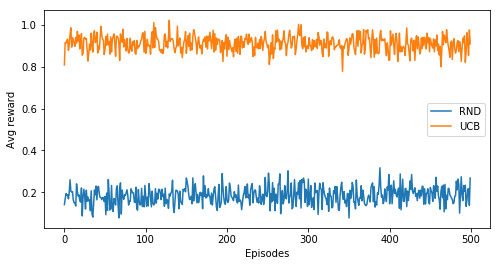

In [64]:
# How does accuracy scale with the number of episodes? it doesnt...
# K = number of episodes

# need to average over?!
player = lambda *x: np.random.randint(0, n_arms)
rnd_regrets = eval_player(bandit, player, 500)

player = UCB(range(n_arms))
ucb_regrets = eval_player(bandit, player, 500)

plt.figure(figsize=(8, 4))

plt.plot(rnd_regrets, label='RND')
plt.plot(ucb_regrets, label='UCB')

plt.xlabel('Episodes')
plt.ylabel('Avg reward')
plt.legend()

# does not improve over many episodes.

In [65]:
def plot_N(player_spec, name):
    # TODO what about how it scales with the number of actions!?
    means = []
    stddevs = []
    
    idx = range(2, 50, 2)
    for n_arms in idx:
        bandit = Env(n_arms)
        player = player_spec(n_arms)
        rs = np.vstack([play_episode(env=bandit, player=player, is_training=False) for _ in range(250)])

        means.append(np.mean(rs[:,-10:]))  # only the last few time steps
        stddevs.append(np.sqrt(np.var(rs[:,-10:])))

    mean = np.array(means)
    stddev = np.array(stddevs)
    
    # smoothing
    n_kernel = 3
    kernel = [1]*n_kernel
    mean = np.convolve(mean, kernel)[:len(mean)]/n_kernel
    stddev = np.convolve(stddev, kernel)[:len(stddev)]/n_kernel

    plt.plot(idx, mean, label=name)
    plt.fill_between(idx, mean-stddev, mean+stddev,  alpha=0.3)

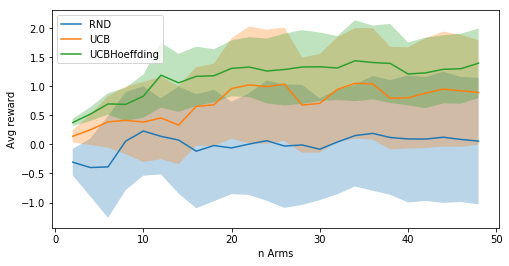

In [66]:
plt.figure(figsize=(8, 4))

player = lambda n_arms: (lambda *x: np.random.randint(0, n_arms))
plot_N(player, 'RND')

player = lambda n_arms: UCB(range(n_arms))
plot_N(player, 'UCB')

player = lambda n_arms: UCBHoeffding(range(n_arms))
plot_N(player, 'UCBHoeffding')

plt.xlabel('n Arms')
plt.ylabel('Avg reward')
plt.legend()

In [67]:
# how can you fairly evaluate this? 
# we have been training on the test data...!?

# how can you apply this to partially observable problems!?


# training this meta learning algol has not be easy...
# not easily learnable? not stable learning!?
# lots of bad local minima
# how can we analyse this!?
# they turn the lr and gamma. should I?

What does this meta learner actually need to learn!?

- To average the rewards (per action) pick the action that has the highest value.
- Also,(in the many arms case) to systematically explore all the different arms.
- To know when a good estimate of the mean has been reached.